# OPTIMIZATION MODEL FOR WASTE PROCESSING ZONE LOCATION IN BOI ZONES

---



**1. Loading Python Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.ops import unary_union
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


**2. Loading Geographic Data**

In [ ]:
# Load Sri Lanka country boundary polygon
world = gpd.read_file('/content/drive/MyDrive/OR_Project/SLBdd/ne_110m_admin_0_countries.shp')
sri_lanka = world[world['NAME'] == 'Sri Lanka']
sri_lanka_polygon = sri_lanka.geometry.unary_union  # single polygon

# Load exclusion zones (combine all shapefiles and geojsons as in prior code)
protected_areas_1 = gpd.read_file('/content/drive/MyDrive/OR_Project/Protected/WDPA_WDOECM_Aug2025_Public_LKA_shp-points.shp')
protected_areas_2 = gpd.read_file('/content/drive/MyDrive/OR_Project/Other/Water_Bodies_and_Rivers.geojson')
buffer_zones = gpd.read_file('/content/drive/MyDrive/OR_Project/Other/Sensitive_Sites_Schools_Hospitals_Religious Places_Parks.geojson')

crs = sri_lanka.crs
exclusion_layers = [protected_areas_1, protected_areas_2, buffer_zones]
for gdf in exclusion_layers:
    if gdf.crs != crs:
        gdf.to_crs(crs, inplace=True)

# Concatenate and merge all exclusion zones into one geometry
all_exclusion = gpd.GeoDataFrame(pd.concat(exclusion_layers, ignore_index=True), crs=crs)
all_exclusion_union = unary_union(all_exclusion.geometry)

# Clip exclusion zones within Sri Lanka boundary
exclusion_clipped = all_exclusion_union.intersection(sri_lanka_polygon)

# Load sensitive site points and buffer radius
# For example, buffer distance in degrees or meters (convert CRS if needed)
sensitive_points = buffer_zones.copy()  # Assuming buffer_zones holds point geometries for sensitive sites
buffer_distance = 0.0001  # example buffer radius (adjust based on CRS units)

# Extract sensitive site coordinates
sensitive_coords = [(geom.x, geom.y) for geom in sensitive_points.geometry]

**3. Loading BOI Zone Data**

In [ ]:
waste_zones_df = pd.DataFrame({
    'x': [79.89003, 80.01001, 80.72304, 80.13906,80.32473],         # longitude
    'y': [7.17128, 6.96089, 6.96002, 6.73220, 5.98870],            # latitude
    'Q': [8074, 7066, 4630, 1547, 2976]              # waste quantities
})

# Parameters
vehicle_capacity = 5  # capacity
cost_per_km = 20         # cost per km

waste_zones_df['Q'] /= 1000
vehicle_capacity /= 1000
cost_per_km /=1000


**4. Helper Functions**

In [ ]:
def inside_sri_lanka(x, y):
    point = Point(x, y)
    return sri_lanka_polygon.contains(point)

def outside_exclusion(x, y):
    point = Point(x, y)
    return not exclusion_clipped.contains(point)

def respect_buffer(x, y):
    for (xf, yf) in sensitive_coords:
        dist = np.sqrt((x - xf)**2 + (y - yf)**2)
        if dist < buffer_distance:
            return False
    return True

def is_feasible(xy):
    x, y = xy
    return inside_sri_lanka(x, y) and outside_exclusion(x, y) and respect_buffer(x, y)

def objective(xy):
    x, y = xy
    # If location violates any constraint, return large penalty cost
    if not is_feasible(xy):
        return 1e9  # large penalty
    total_cost = 0
    for _, row in waste_zones_df.iterrows():
        xi, yi, Qi = row['x'], row['y'], row['Q']
        ni = np.ceil(Qi / vehicle_capacity)
        ti = np.sqrt((xi - x)**2 + (yi - y)**2)
        total_cost += cost_per_km * ni * ti
    return total_cost

**5. Optimization**

In [ ]:
# Initial guess: centroid of Sri Lanka polygon
centroid = sri_lanka_polygon.centroid
x0 = [centroid.x, centroid.y]

# Bounds: approx bounding box of Sri Lanka polygon to limit search space
minx, miny, maxx, maxy = sri_lanka_polygon.bounds
bounds = [(minx, maxx), (miny, maxy)]

result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)

if result.success:
    opt_x, opt_y = result.x
    print(f"Optimal WMS location found at: ({opt_x}, {opt_y})")
    print(" ")
else:
    print("Optimization failed:", result.message)

Optimal WMS location found at: (80.01001000540596, 6.960889995800285)
 


**6. Condition Confirmation of Output**

In [ ]:
print(inside_sri_lanka(opt_x, opt_y))
print(outside_exclusion(opt_x, opt_y))
print(respect_buffer(opt_x, opt_y))


True
True
True


**7. Visualization**

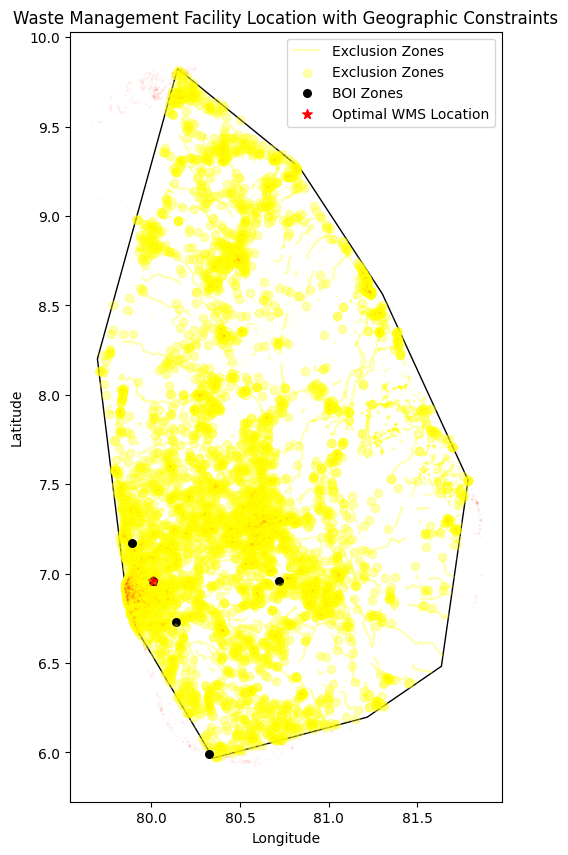

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
# Plot Sri Lanka boundary
sri_lanka.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot exclusion zones
exclusion_gdf = gpd.GeoDataFrame(geometry=[exclusion_clipped], crs=crs)
exclusion_gdf.plot(ax=ax, color='yellow', alpha=0.3, label='Exclusion Zones')

# Plot sensitive site buffer zones
for (xf, yf) in sensitive_coords:
    circle = plt.Circle((xf, yf), buffer_distance, color='red', alpha=0.3)
    ax.add_patch(circle)

# Plot waste zones

ax.scatter(waste_zones_df['x'], waste_zones_df['y'], s=30, color='black', label='BOI Zones')

# Plot optimal facility location
ax.scatter([opt_x], [opt_y], color='red', marker='*', s=50, label='Optimal WMS Location')

ax.legend()
plt.title('Waste Management Facility Location with Geographic Constraints')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Accuracy Checking

Optimal WMS location found at: (80.08463393870412, 6.909629481921735)
 


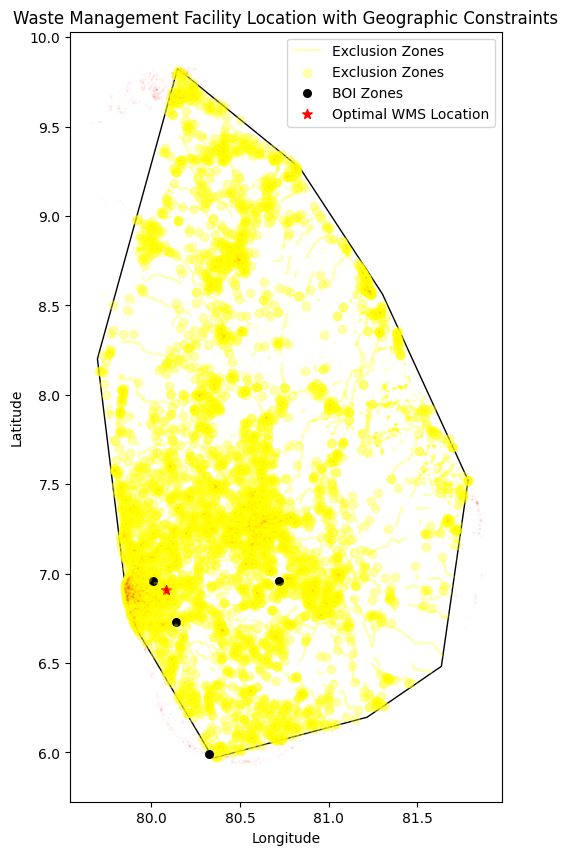

In [ ]:
waste_zones_df = pd.DataFrame({
    'x': [80.01001, 80.72304, 80.13906,80.32473],         # longitude
    'y': [6.96089, 6.96002, 6.73220, 5.98870],            # latitude
    'Q': [7066, 4630, 1547, 2976]              # waste quantities
})


# Parameters
vehicle_capacity = 5  # capacity
cost_per_km = 20         # cost per km

waste_zones_df['Q'] /= 1000
vehicle_capacity /= 1000
cost_per_km /=1000

# Initial guess: centroid of Sri Lanka polygon
centroid = sri_lanka_polygon.centroid
x0 = [centroid.x, centroid.y]

# Bounds: approx bounding box of Sri Lanka polygon to limit search space
minx, miny, maxx, maxy = sri_lanka_polygon.bounds
bounds = [(minx, maxx), (miny, maxy)]

result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)

if result.success:
    opt_x, opt_y = result.x
    print(f"Optimal WMS location found at: ({opt_x}, {opt_y})")
    print(" ")
else:
    print("Optimization failed:", result.message)

fig, ax = plt.subplots(figsize=(10,10))
# Plot Sri Lanka boundary
sri_lanka.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot exclusion zones
exclusion_gdf = gpd.GeoDataFrame(geometry=[exclusion_clipped], crs=crs)
exclusion_gdf.plot(ax=ax, color='yellow', alpha=0.3, label='Exclusion Zones')

# Plot sensitive site buffer zones
for (xf, yf) in sensitive_coords:
    circle = plt.Circle((xf, yf), buffer_distance, color='red', alpha=0.3)
    ax.add_patch(circle)

# Plot waste zones

ax.scatter(waste_zones_df['x'], waste_zones_df['y'], s=30, color='black', label='BOI Zones')

# Plot optimal facility location
ax.scatter([opt_x], [opt_y], color='red', marker='*', s=50, label='Optimal WMS Location')

ax.legend()
plt.title('Waste Management Facility Location with Geographic Constraints')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Optimal WMS location found at: (80.72303997527727, 6.960019969226438)
 


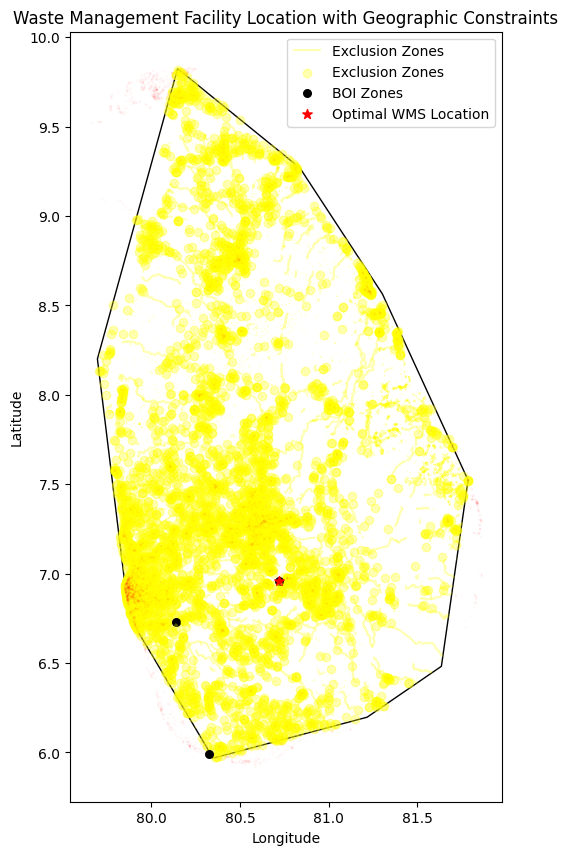

In [ ]:
waste_zones_df = pd.DataFrame({
    'x': [80.72304, 80.13906,80.32473],         # longitude
    'y': [6.96002, 6.73220, 5.98870],            # latitude
    'Q': [4630, 1547, 2976]              # waste quantities
})


# Parameters
vehicle_capacity = 5  # capacity
cost_per_km = 20         # cost per km

waste_zones_df['Q'] /= 1000
vehicle_capacity /= 1000
cost_per_km /=1000

# Initial guess: centroid of Sri Lanka polygon
centroid = sri_lanka_polygon.centroid
x0 = [centroid.x, centroid.y]

# Bounds: approx bounding box of Sri Lanka polygon to limit search space
minx, miny, maxx, maxy = sri_lanka_polygon.bounds
bounds = [(minx, maxx), (miny, maxy)]

result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)

if result.success:
    opt_x, opt_y = result.x
    print(f"Optimal WMS location found at: ({opt_x}, {opt_y})")
    print(" ")
else:
    print("Optimization failed:", result.message)

fig, ax = plt.subplots(figsize=(10,10))
# Plot Sri Lanka boundary
sri_lanka.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot exclusion zones
exclusion_gdf = gpd.GeoDataFrame(geometry=[exclusion_clipped], crs=crs)
exclusion_gdf.plot(ax=ax, color='yellow', alpha=0.3, label='Exclusion Zones')

# Plot sensitive site buffer zones
for (xf, yf) in sensitive_coords:
    circle = plt.Circle((xf, yf), buffer_distance, color='red', alpha=0.3)
    ax.add_patch(circle)

# Plot waste zones

ax.scatter(waste_zones_df['x'], waste_zones_df['y'], s=30, color='black', label='BOI Zones')

# Plot optimal facility location
ax.scatter([opt_x], [opt_y], color='red', marker='*', s=50, label='Optimal WMS Location')

ax.legend()
plt.title('Waste Management Facility Location with Geographic Constraints')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Optimal WMS location found at: (79.8900299990668, 7.171279993651219)
 


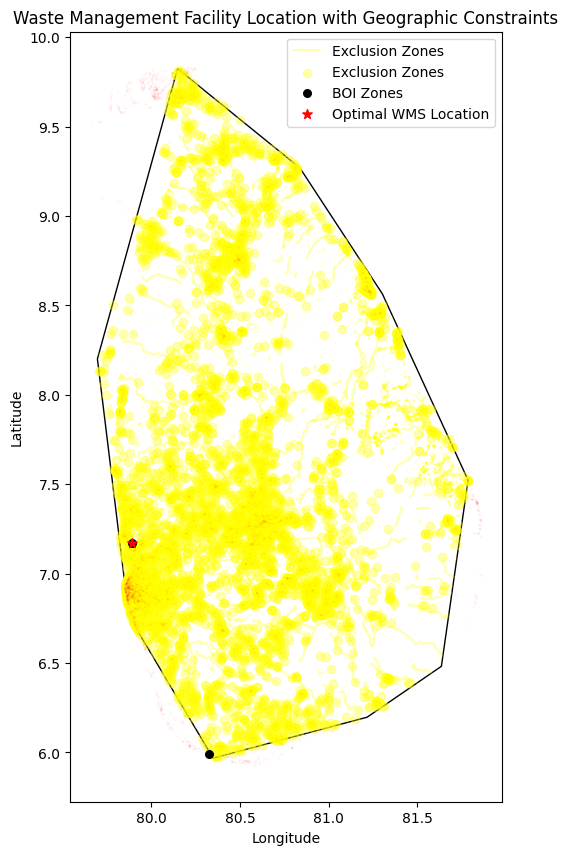

In [ ]:
waste_zones_df = pd.DataFrame({
    'x': [79.89003, 80.32473],         # longitude
    'y': [7.17128, 5.98870],            # latitude
    'Q': [8074, 2976]              # waste quantities
})

# Initial guess: centroid of Sri Lanka polygon
centroid = sri_lanka_polygon.centroid
x0 = [centroid.x, centroid.y]

# Bounds: approx bounding box of Sri Lanka polygon to limit search space
minx, miny, maxx, maxy = sri_lanka_polygon.bounds
bounds = [(minx, maxx), (miny, maxy)]

result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)

if result.success:
    opt_x, opt_y = result.x
    print(f"Optimal WMS location found at: ({opt_x}, {opt_y})")
    print(" ")
else:
    print("Optimization failed:", result.message)

fig, ax = plt.subplots(figsize=(10,10))
# Plot Sri Lanka boundary
sri_lanka.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot exclusion zones
exclusion_gdf = gpd.GeoDataFrame(geometry=[exclusion_clipped], crs=crs)
exclusion_gdf.plot(ax=ax, color='yellow', alpha=0.3, label='Exclusion Zones')

# Plot sensitive site buffer zones
for (xf, yf) in sensitive_coords:
    circle = plt.Circle((xf, yf), buffer_distance, color='red', alpha=0.3)
    ax.add_patch(circle)

# Plot waste zones

ax.scatter(waste_zones_df['x'], waste_zones_df['y'], s=30, color='black', label='BOI Zones')

# Plot optimal facility location
ax.scatter([opt_x], [opt_y], color='red', marker='*', s=50, label='Optimal WMS Location')

ax.legend()
plt.title('Waste Management Facility Location with Geographic Constraints')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()